In [70]:
import os
os.chdir('/home/renwh/gaze/renwh/caffe_with_cudnnv3/')

import sys
sys.path.insert(0,'./python')
import caffe

from pylab import *
%matplotlib inline


caffe.set_device(0)
caffe.set_mode_gpu()
solver = caffe.SGDSolver('examples/mymodel/05/quick_solver.prototxt')

#You can choose to load your model status
#solver.restore('examples/mymodel/03/lenet_iter_1001.solverstate')

In [71]:
# each output is (batch size, feature dim, spatial dim)
[(k, v.data.shape) for k, v in solver.net.blobs.items()]
#[(k, v.data.shape) for k, v in solver.test_nets[0].blobs.items()]

[('data', (1000, 1, 36, 60)),
 ('label', (1000, 6)),
 ('gaze', (1000, 3)),
 ('headpose', (1000, 3)),
 ('conv1/5x5_s1', (1000, 64, 32, 56)),
 ('pool1/3x3_s2', (1000, 64, 16, 28)),
 ('pool1/norm1', (1000, 64, 16, 28)),
 ('pool1/norm1_pool1/norm1_0_split_0', (1000, 64, 16, 28)),
 ('pool1/norm1_pool1/norm1_0_split_1', (1000, 64, 16, 28)),
 ('pool1/norm1_pool1/norm1_0_split_2', (1000, 64, 16, 28)),
 ('pool1/norm1_pool1/norm1_0_split_3', (1000, 64, 16, 28)),
 ('inception_1/1x1', (1000, 64, 16, 28)),
 ('inception_1/3x3_reduce', (1000, 96, 16, 28)),
 ('inception_1/3x3', (1000, 128, 16, 28)),
 ('inception_1/5x5_reduce', (1000, 16, 16, 28)),
 ('inception_1/5x5', (1000, 32, 16, 28)),
 ('inception_1/pool', (1000, 64, 16, 28)),
 ('inception_1/pool_proj', (1000, 32, 16, 28)),
 ('inception_1/output', (1000, 256, 16, 28)),
 ('pool2/3x3_s2', (1000, 256, 8, 14)),
 ('conv2/3x3_s1', (1000, 64, 6, 12)),
 ('pool3/2x2_s2', (1000, 64, 3, 6)),
 ('ip1', (1000, 500)),
 ('cat', (1000, 503)),
 ('ip2', (1000, 3)),


In [72]:
# just print the weight sizes (not biases)
[(k, v[0].data.shape) for k, v in solver.net.params.items()]

[('conv1/5x5_s1', (64, 1, 5, 5)),
 ('inception_1/1x1', (64, 64, 1, 1)),
 ('inception_1/3x3_reduce', (96, 64, 1, 1)),
 ('inception_1/3x3', (128, 96, 3, 3)),
 ('inception_1/5x5_reduce', (16, 64, 1, 1)),
 ('inception_1/5x5', (32, 16, 5, 5)),
 ('inception_1/pool_proj', (32, 64, 1, 1)),
 ('conv2/3x3_s1', (64, 256, 3, 3)),
 ('ip1', (500, 1152)),
 ('ip2', (3, 503))]

In [73]:
solver.net.forward()  # train net
solver.test_nets[0].forward()  # test net (there can be more than one)

{'loss': array(0.22019138932228088, dtype=float32)}

[[ -2.44513273e-01   5.20949736e-02  -9.68245506e-01  -5.07045567e-01
   -1.12138920e-01  -2.90884897e-02]
 [ -7.41908699e-02   2.27922529e-01  -9.70848620e-01  -1.28387764e-01
    1.65355857e-02   1.06296828e-03]
 [ -1.74087971e-01   3.04691344e-02  -9.84258592e-01  -9.52000245e-02
   -3.14195365e-01  -1.50917871e-02]
 [ -2.49744281e-02   1.77879885e-01  -9.83735263e-01  -7.38587156e-02
   -1.21144764e-02  -4.47588827e-04]
 [ -1.61419377e-01   5.79187945e-02  -9.85184848e-01  -1.06810793e-01
    1.42905980e-01   7.65229668e-03]
 [ -1.52415037e-01   2.09456533e-01  -9.65866268e-01  -5.29863574e-02
   -1.14266567e-01  -3.03129526e-03]
 [ -1.76816806e-02   6.62708879e-02  -9.97644961e-01  -6.35477304e-02
   -2.95568883e-01  -9.46362782e-03]
 [  1.79661021e-01   2.34958977e-01  -9.55257118e-01  -8.40480402e-02
    1.60711512e-01   6.77234307e-03]]


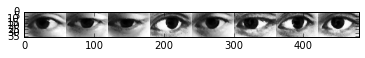

In [74]:
# we use a little trick to tile the first eight images
imshow(solver.test_nets[0].blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(36, 8*60), cmap='gray')
print solver.net.blobs['label'].data[:8]

In [75]:
solver.step(1)

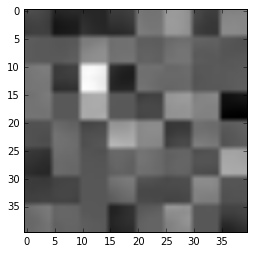

In [76]:
imshow(solver.net.params['conv1/5x5_s1'][0].diff[:, 0].reshape(8, 8, 5, 5)
       .transpose(0, 2, 1, 3).reshape(8*5, 8*5), cmap='gray')

Show the conv1 weights pics.


Then, I will train the model, and log some information.

In [77]:
%%time
niter = 1000
test_interval = 25
# losses will also be stored in the log
train_loss = zeros(niter)
mean_error= zeros(int(np.ceil(niter / test_interval)))
output = zeros((niter, 8, 3))

# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    
    # store the output on the first test batch
    # (start the forward pass at conv1 to avoid loading new data)
    solver.test_nets[0].forward(start='conv1/5x5_s1')
    output[it] = solver.test_nets[0].blobs['ip2'].data[:8]
    if it % test_interval == 0:
        # caculate the square error for each gaze vector
        solver.test_nets[0].forward()
        
        num_test = 100;
        sub_error = zeros((num_test, 3))
        square_error = zeros((num_test, 3))
        sum_Euclidean_error = zeros(num_test)
        for i in range(num_test):
            sub_error[i,:] = np.subtract(solver.test_nets[0].blobs['gaze'].data[i]
                                         , solver.test_nets[0].blobs['ip2'].data[i])
            square_error = np.square(sub_error)
            sum_Euclidean_error = np.sum(square_error,1)
            sum_Euclidean_error = np.sqrt(sum_Euclidean_error)/6
        mean_error[it // test_interval] = np.sum(sum_Euclidean_error,0)/num_test*180
        print 'Iteration', it, '. Mean error is', mean_error[it // test_interval]

Iteration 0 . Mean error is 54.6342692982
Iteration 25 . Mean error is 13.9690452568
Iteration 50 . Mean error is 6.01857395284
Iteration 75 . Mean error is 5.60430387924
Iteration 100 . Mean error is 5.96310669959
Iteration 125 . Mean error is 5.6229663412
Iteration 150 . Mean error is 5.84459885677
Iteration 175 . Mean error is 5.41416189372
Iteration 200 . Mean error is 6.10767730173
Iteration 225 . Mean error is 5.37393612815
Iteration 250 . Mean error is 5.53257661499
Iteration 275 . Mean error is 6.33604649726
Iteration 300 . Mean error is 5.14323877841
Iteration 325 . Mean error is 5.9091166962
Iteration 350 . Mean error is 5.81262739748
Iteration 375 . Mean error is 5.26354606345
Iteration 400 . Mean error is 6.02054334492
Iteration 425 . Mean error is 5.51234113904
Iteration 450 . Mean error is 5.54850200525
Iteration 475 . Mean error is 5.53542634679
Iteration 500 . Mean error is 5.29325781219
Iteration 525 . Mean error is 5.98167357063
Iteration 550 . Mean error is 5.5258470

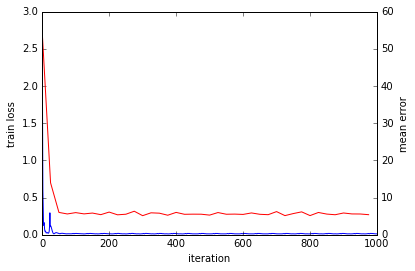

In [78]:
_, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(arange(niter), train_loss)
ax2.plot(test_interval * arange(len(mean_error)), mean_error, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('mean error')

**show you the train loss curve.

--------------------------------------------------------------------------------------------------------------
1000 test pic, mean error is  5.57107542156 degree


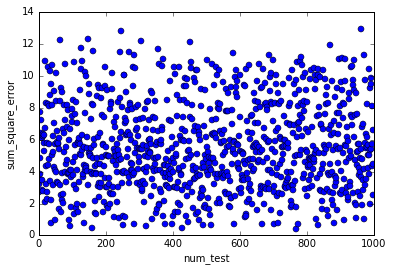

In [79]:
num_test = 1000


# (start the forward pass at conv1 to avoid loading new data)
solver.test_nets[0].forward(start='conv1/5x5_s1')
solver.test_nets[0].forward()

#figure(figsize=(10, 5))
#imshow(solver.test_nets[0].blobs['data'].data[:num_test, 0].transpose(1, 0, 2).reshape(36, num_test*60), cmap='gray')
    
#Print the label and train result
#for i in range(num_test):
#    print solver.test_nets[0].blobs['label'].data[i,:3] ,'label<->ip2', solver.test_nets[0].blobs['ip2'].data[i]

print '--------------------------------------------------------------------------------------------------------------'
# caculate the square error for each gaze vector
sub_error = zeros((num_test, 3))
square_error = zeros((num_test, 3))
sum_square_error = zeros(num_test)
for i in range(num_test):
    sub_error[i,:] = np.subtract(solver.test_nets[0].blobs['label'].data[i,:3], solver.test_nets[0].blobs['ip2'].data[i])
    square_error = np.square(sub_error)
    sum_square_error = np.sum(square_error,1)
    sum_square_error = np.sqrt(sum_square_error)/6
    #print sub_error[i,:],square_error[i,:],sum_square_error[i]
    #print sum_square_error[i],

print num_test,'test pic, mean error is ',np.sum(sum_square_error,0)/num_test*180,'degree'
_, ax1 = subplots()
ax1.plot(arange(num_test), sum_square_error*180,'bo', label='sampled')
ax1.set_xlabel('num_test')
ax1.set_ylabel('sum_square_error')
    

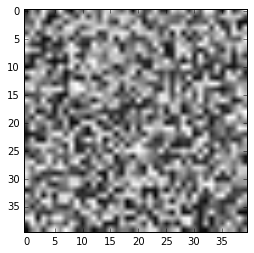

In [80]:
imshow(solver.net.params['conv1/5x5_s1'][0].diff[:, 0].reshape(8, 8, 5, 5)
       .transpose(0, 2, 1, 3).reshape(8*5, 8*5), cmap='gray')

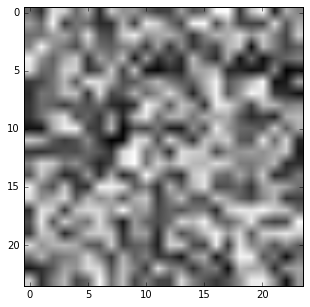

In [81]:
figure(figsize=(10, 5))
imshow(solver.net.params['conv2/3x3_s1'][0].diff[:, 0].reshape(8, 8, 3, 3)
       .transpose(0, 2, 1, 3).reshape(8*3, 8*3), cmap='gray')

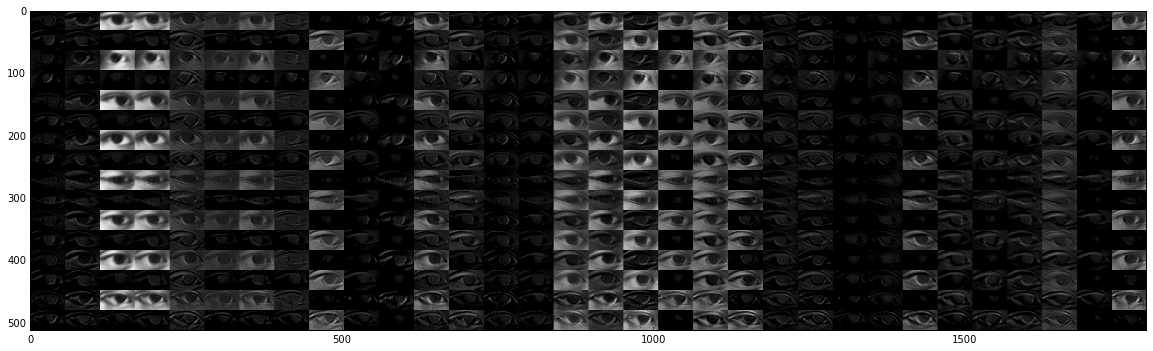

In [82]:
figure(figsize=(20, 10))
imshow(solver.test_nets[0].blobs['conv1/5x5_s1'].data[:8, :].reshape(16,32,32,56)
           .transpose(0,2,1,3).reshape(16*32, 32*56), cmap='gray')

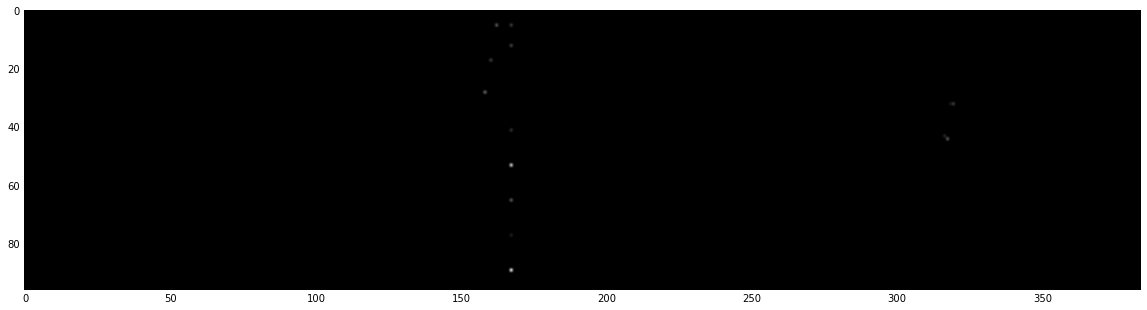

In [83]:
figure(figsize=(20, 10))
imshow(solver.test_nets[0].blobs['conv2/3x3_s1'].data[:8, :].reshape(16, 32, 6, 12)
       .transpose(0,2,1,3).reshape(16*6,32*12), cmap='gray')

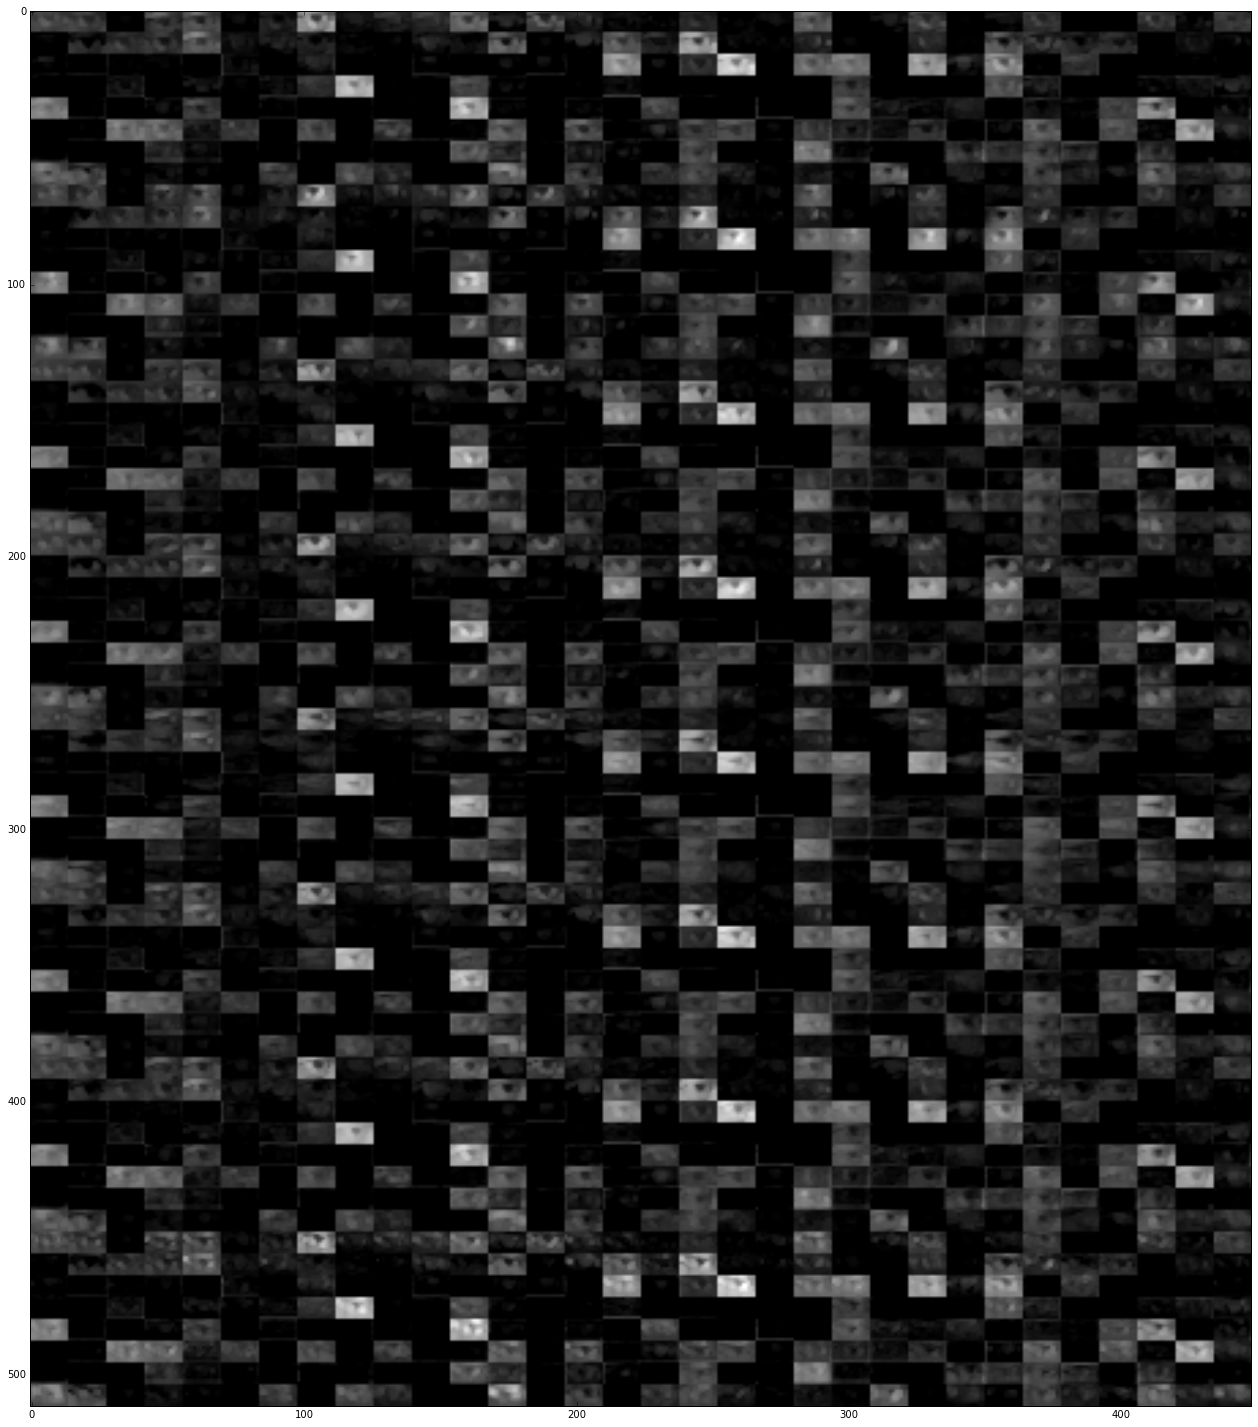

In [84]:
figure(figsize=(50, 25))
imshow(solver.test_nets[0].blobs['pool2/3x3_s2'].data[:8, :].reshape(64, 32, 8, 14)
       .transpose(0,2,1,3).reshape(64*8,32*14), cmap='gray')


In [16]:
#solver.net.save('my_model.caffemodel') I do not know how to use this.
solver.snapshot() #SAVE MY MODEL IN THE DIR YOU DEFINE IN SOLVER FILE.